First, we activate the right Julia environment and add missing packages.

Afterwards, Julia will have to precompile the environment again. This may take some time ...

In [1]:
using Pkg
Pkg.activate("./")
Pkg.add("Zygote")
Pkg.add("Plots")
Pkg.status()

  Activating project at `c:\Users\jakdar\Uni\bachelorarbeit\VeryDiff`
    Updating registry at `C:\Users\jakdar\.julia\registries\General.toml`
   Resolving package versions...
      Compat entries added for 
  No Changes to `C:\Users\jakdar\Uni\bachelorarbeit\VeryDiff\Project.toml`
  No Changes to `C:\Users\jakdar\Uni\bachelorarbeit\VeryDiff\Manifest.toml`
   Resolving package versions...
      Compat entries added for 
  No Changes to `C:\Users\jakdar\Uni\bachelorarbeit\VeryDiff\Project.toml`
  No Changes to `C:\Users\jakdar\Uni\bachelorarbeit\VeryDiff\Manifest.toml`


Project VeryDiff v0.1.0
Status `C:\Users\jakdar\Uni\bachelorarbeit\VeryDiff\Project.toml`
  [c7e460c6] ArgParse v1.2.0
⌅ [864edb3b] DataStructures v0.18.20
  [60bf3e95] GLPK v1.2.1
  [2e9cd046] Gurobi v1.0.2 `https://github.com/jump-dev/Gurobi.jl.git#v1.0.2` ⚲
⌃ [4076af6c] JuMP v1.22.2
  [e3e6debb] MaskedArrays v0.2.0
⌃ [9b87118b] PackageCompiler v2.2.0
  [91a5bcdd] Plots v1.41.1
⌃ [d1185830] SymbolicUtils v1.1.0 ⚲
⌃ [811555cd] ThreadPinning v0.7.22
⌃ [a759f4b9] TimerOutputs v0.5.24
  [286915b0] VNNLib v0.2.3 `https://github.com/samysweb/VNNLib.jl#c6bf990`
  [e88e6eb3] Zygote v0.7.10
  [37e2e46d] LinearAlgebra v1.11.0
  [9a3f8284] Random v1.11.0
  [2f01184e] SparseArrays v1.11.0
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


In [2]:
using VeryDiff, VNNLib, Zygote, Plots, LinearAlgebra

Set parameter Username
Academic license - for non-commercial use only - expires 2026-10-27


# Gradient-based Attacks

We define the *fast gradient sign method* (FGSM) and *projected gradient descent* (PGD).

In [3]:
function fgsm(net1, net2, x, lbs, ubs, loss_fn; step_size=0.1)
    y, ∇ = withgradient(x -> loss_fn(net1(x), net2(x)), x)
    return clamp.(x .- ∇[1] .* step_size, lbs, ubs)
end

function pgd(net1, net2, x, lbs, ubs, loss_fn; step_size=0.01, iterations=100)
    best_y = Inf
    best_x = x
    
    for i in 1:iterations
        y, ∇ = withgradient(x -> loss_fn(net1(x), net2(x)), x)

        if y < best_y
            best_y = y
            best_x = x
        end

        x = clamp.(x .- ∇[1] .* step_size, lbs, ubs)
    end

    return best_x
end 

pgd (generic function with 1 method)

Then, we define a loss function to maximize the violation of $\epsilon$-equivalence.

In [4]:
ϵ_equiv_loss = (y1, y2) -> .-maximum(abs.(y1 .- y2))

#17 (generic function with 1 method)

And we can try to find concrete images that violate the $\epsilon$-equivalence property for concrete networks.

In [5]:
# net1 = load_network("/data/mnist_relu_3_100.onnx");
# net2 = load_network("/data/mnist_relu_3_100_pruned5.onnx");
net1 = load_network("./test/examples/nets/mnist_relu_3_100.onnx")
net2 = load_network("./test/examples/nets/mnist_relu_3_100_pruned5.onnx")

Found input X
op: matmul, weight: (100, 784), bias: nothing
op: bias, weight: nothing, bias: (100,)
op: relu, weight: nothing, bias: nothing
op: matmul, weight: (100, 100), bias: nothing
op: bias, weight: nothing, bias: (100,)
op: relu, weight: nothing, bias: nothing
op: matmul, weight: (10, 100), bias: nothing
op: bias, weight: nothing, bias: (10,)
op: relu, weight: nothing, bias: nothing
op: matmul, weight: (10, 10), bias: nothing
op: bias, weight: nothing, bias: (10,)
Found input X
op: matmul, weight: (100, 784), bias: nothing
op: bias, weight: nothing, bias: (100,)
op: relu, weight: nothing, bias: nothing
op: matmul, weight: (100, 100), bias: nothing
op: bias, weight: nothing, bias: (100,)
op: relu, weight: nothing, bias: nothing
op: matmul, weight: (10, 100), bias: nothing
op: bias, weight: nothing, bias: (10,)
op: relu, weight: nothing, bias: nothing
op: matmul, weight: (10, 10), bias: nothing
op: bias, weight: nothing, bias: (10,)


Network(Layer[Dense([-0.13619999587535858 0.03020000085234642 … 0.10394000262022018 -0.08606000244617462; -0.16459999978542328 0.13369999825954437 … 0.1428000032901764 -0.04535000026226044; … ; -0.04275999963283539 0.08420000225305557 … -0.04024999961256981 -0.14640000462532043; -0.03505999967455864 0.1071000024676323 … 0.037450000643730164 -0.021970000118017197], [0.09679999947547913, 0.14839999377727509, 0.04645000025629997, 0.1012599989771843, 0.10064999759197235, 0.11760000139474869, 0.20430000126361847, 0.22509999573230743, 0.18700000643730164, 0.1543000042438507  …  0.12020000070333481, 0.026280000805854797, 0.1662999987602234, 0.06629999727010727, -1.0, 0.09503000229597092, 0.09839999675750732, 0.09264999628067017, -0.013144999742507935, 0.15330000221729279]), ReLU(), Dense([-0.0029750000685453415 0.17589999735355377 … -0.11540000140666962 0.1940000057220459; 0.010359999723732471 0.08910000324249268 … -0.00953999999910593 0.011070000007748604; … ; -0.04913000017404556 0.11816000

Select an input set, we want to test.

In [6]:
# try one of those
f, n_in, n_out = get_ast("./test/examples/specs/mnist_7_local_15.vnnlib")
# f, n_in, n_out = get_ast("/data/mnist_90_global_4.vnnlib");
# f, n_in, n_out = get_ast("/data/mnist_9_global_3.vnnlib");

((and (<= 0.0 X_0 ) (<= X_0 0.0 ) (<= 0.0 X_1 ) (<= X_1 0.0 ) (<= 0.0 X_2 ) (<= X_2 0.0 ) (<= 0.0 X_3 ) (<= X_3 0.0 ) (<= 0.0 X_4 ) (<= X_4 0.0 ) (<= 0.0 X_5 ) (<= X_5 0.0 ) (<= 0.0 X_6 ) (<= X_6 0.0 ) (<= 0.0 X_7 ) (<= X_7 0.0 ) (<= 0.0 X_8 ) (<= X_8 0.0 ) (<= 0.0 X_9 ) (<= X_9 0.0 ) (<= 0.0 X_10 ) (<= X_10 0.0 ) (<= 0.0 X_11 ) (<= X_11 0.0 ) (<= 0.0 X_12 ) (<= X_12 0.0 ) (<= 0.0 X_13 ) (<= X_13 0.0 ) (<= 0.0 X_14 ) (<= X_14 0.0 ) (<= 0.0 X_15 ) (<= X_15 0.0 ) (<= 0.0 X_16 ) (<= X_16 0.0 ) (<= 0.0 X_17 ) (<= X_17 0.0 ) (<= 0.0 X_18 ) (<= X_18 0.0 ) (<= 0.0 X_19 ) (<= X_19 0.0 ) (<= 0.0 X_20 ) (<= X_20 0.0 ) (<= 0.0 X_21 ) (<= X_21 0.0 ) (<= 0.0 X_22 ) (<= X_22 0.0 ) (<= 0.0 X_23 ) (<= X_23 0.0 ) (<= 0.0 X_24 ) (<= X_24 0.0 ) (<= 0.0 X_25 ) (<= X_25 0.0 ) (<= 0.0 X_26 ) (<= X_26 0.0 ) (<= 0.0 X_27 ) (<= X_27 0.0 ) (<= 0.0 X_28 ) (<= X_28 0.0 ) (<= 0.0 X_29 ) (<= X_29 0.0 ) (<= 0.0 X_30 ) (<= X_30 0.0 ) (<= 0.0 X_31 ) (<= X_31 0.0 ) (<= 0.0 X_32 ) (<= X_32 0.0 ) (<= 0.0 X_33 ) (<= X_33 

And try to find an input with a maximal absolute difference $> 1$.

In [7]:
x0 = nothing
x1 = nothing
for (bounds, matrix, bias, num) in f
   lbs = bounds[1:n_in,1]
   ubs = bounds[1:n_in,2]
   x0 = 0.5 .* (lbs .+ ubs)
   x1 = pgd(net1, net2, x0, lbs, ubs, ϵ_equiv_loss)


   @show net1(x0)
   @show net2(x0)
   @show ϵ_equiv_loss(net1(x0), net2(x0))
   @show ϵ_equiv_loss(net1(x1), net2(x1))
end

net1(x0) = [0.0, 0.0, 1.7083849941209432, 3.0504748526751433, 0.3711981519045434, 0.0, 0.0, 1.2612268850192567, 0.0, 4.551974937734407]
net2(x0) = [0.0, 0.0, 1.721434851408797, 2.9501600329211053, 0.3120287481167475, 0.0, 0.0, 1.062254630019375, 0.0, 4.561008320651856]
ϵ_equiv_loss(net1(x0), net2(x0)) = -0.1989722549998818
ϵ_equiv_loss(net1(x1), net2(x1)) = -0.20449944864084313


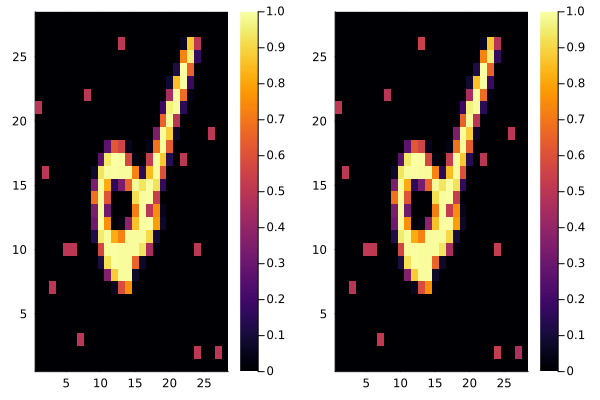

In [8]:
p1 = heatmap(reshape(x0, 28, 28)')
p2 = heatmap(reshape(x1, 28, 28)')

plot(p1, p2)

# Zonotopes Introduction

Zonotopes can be created via their generator matrix and center.

We can also plot 2D Zonotopes.

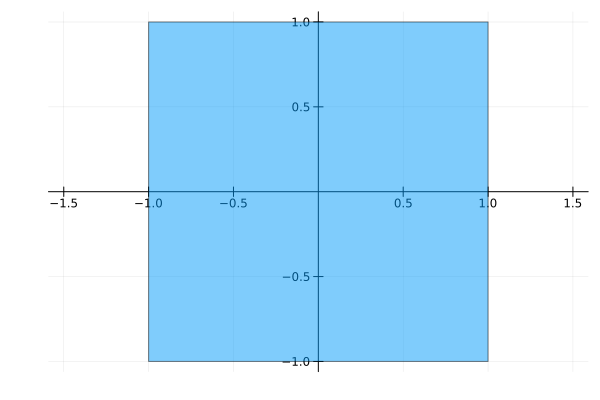

In [9]:
include("util.jl")

#            G     c
z = Zonotope(I(2), zeros(2), nothing)

plot(z, alpha=0.5, framestyle=:origin, aspect_ratio=:equal)

Can you create a Zonotope that represents a (not necessarily regular) 2-dimensional hexagon or octagon?

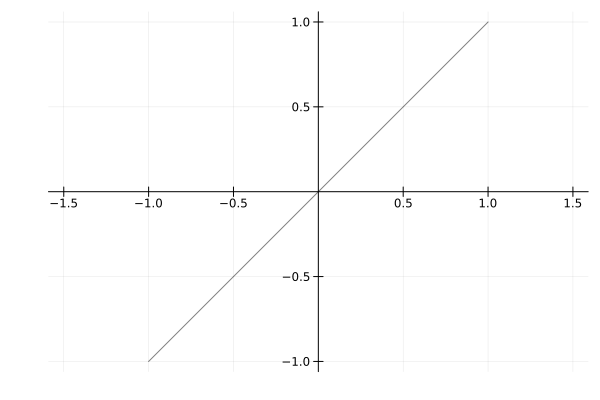

In [10]:
z = Zonotope(Matrix([1.0 0; 1.0 0]), zeros(2), nothing)

plot(z, alpha=0.5, framestyle=:origin, aspect_ratio=:equal)

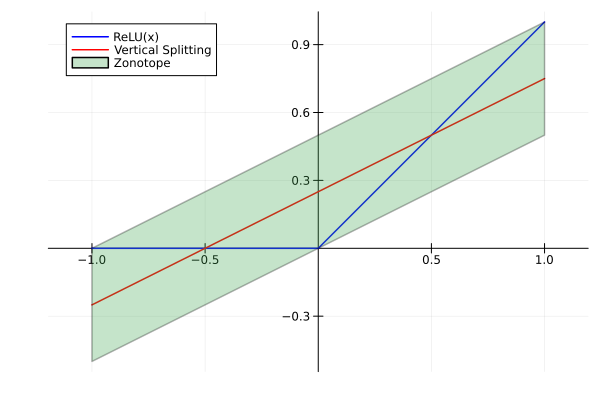

In [11]:
x = range(-1, 1, length=1000)
y = max.(x, 0)

λ = 0.5
u = λ * x .+ λ
l = λ * x
m = 0.5 * (u + l)
# ̂y = λx + λϵ
linewidth = 1.5

plot(x, y, label="ReLU(x)", lc=:blue, lw=linewidth)
# plot!(x, l, label="lower(x)", lc=:blue)
# plot!(x, u , label="upper(x)", lc=:green)
plot!(x, m , label="Vertical Splitting", lc=:red, lw=linewidth)

#            G     c
z = Zonotope(Matrix([1.0 0; λ -λ*λ]), [0, 0.5*λ], nothing)
plot!(z, alpha=0.3, label="Zonotope", framestyle=:origin, aspect_ratio=:equal, lw=linewidth)

# z = Zonotope(Matrix([1.0 0; λ -λ*λ*λ]), [0, 0.5*λ*(λ + 1.0)], nothing)
# plot!(z, alpha=0.3, label="Zonotope Z1", framestyle=:origin, aspect_ratio=:equal, lw=linewidth)

# z = Zonotope(Matrix([1.0 0; λ -λ*λ*λ]), [0, 0.5*λ*λ], nothing)
# plot!(z, alpha=0.3, label="Zonotope Z2", framestyle=:origin, aspect_ratio=:equal, lw=linewidth)

# savefig("vertical_splitting.png")

In [12]:
function affine_transform(L::Dense, Z :: Zonotope)
    return begin
        G = L.W * Z.G
        c = L.W * Z.c .+ L.b
        return Zonotope(G, c, Z.influence)
    end
end

function relu_transform_alt(Z :: Zonotope)
    return begin
        bounds = zono_bounds(Z)
        lower = bounds[:, 1]
        upper = bounds[:, 2]
        
        α = clamp.(upper./(upper.-lower), 0.0, 1.0)
        λ = ifelse.(upper.<=0.0, 0.0, ifelse.(lower.>=0.0, 1.0, α))
        crossing = lower.<0.0 .&& upper.>0.0
        γ = 0.5 .* max.(-λ .* lower, 0.0, ((-).(1.0,λ)).*upper)  # Computed offset (-λl/2)
        
        ĉ = λ .* Z.c .+ crossing.*γ

        row_count = size(Z.G, 1)
        Ĝ = zeros(Float64, row_count, size(Z.G,2)+1)

        Ĝ[:,1:size(Z.G,2)] .= Z.G
        Ĝ[crossing,size(Z.G,2)+1] .= 1.0

        Ĝ[:,1:size(Z.G,2)] .*= λ
        Ĝ[:,size(Z.G,2)+1] .*= abs.(γ)

        return Zonotope(Ĝ, ĉ, Z.influence)
    end
end

function relu_transform(Z :: Zonotope)
    return begin
        bounds = zono_bounds(Z)
        lower = bounds[:, 1]
        upper = bounds[:, 2]
        
        α = clamp.(upper./(upper.-lower), 0.0, 1.0)
        λ = ifelse.(upper.<=0.0, 0.0, ifelse.(lower.>=0.0, 1.0, α))
        crossing = lower.<0.0 .&& upper.>0.0
        γ = 0.5 .* max.(-λ .* lower, 0.0, ((-).(1.0,λ)).*upper)  # Computed offset (-λl/2)
        
        ĉ = λ .* Z.c .+ crossing.*γ

        row_count = size(Z.G, 1)
        Ĝ = zeros(Float64, row_count, size(Z.G,2)+count(crossing))

        Ĝ[:,1:size(Z.G,2)] .= Z.G
        Ĝ[crossing,size(Z.G,2)+1:end] .=  (@view I(row_count)[crossing, crossing])

        Ĝ[:,1:size(Z.G,2)] .*= λ
        Ĝ[:,size(Z.G,2)+1:end] .*= abs.(γ)

        return Zonotope(Ĝ, ĉ, Z.influence)
    end
end

relu_transform (generic function with 1 method)

In [13]:
Z₀ = Zonotope([2.0 0.0; 0.0 -1.0], [0, 1], nothing)

f₁ = Dense([-1.0 2.0; 1.0 0.0], [0.0, 1]) #Dense([1.0 1.0; 1.0 2.0], [1.0, 1.0])
f₂ = Dense([3.0 1.0; 1.0 1.0], [1.0, 0.0]) #Dense([1.0 1.0; 2.0 1.0], [1.0, 1.0])
f₃ = Dense([1.0 -1.0; -5.0 1.0], [1.0, 2.0]) #Dense([1.0 2.0; 1.0 1.0], [1.0, 1.0])
f₄ = Dense([-3.0 1.0; -2.0 5.5], [1.0, -1.0]) #Dense([2.0 1.0; 1.0 1.0], [1.0, 1.0])

layers = [f₁, f₂, f₃, f₄]

Z = Z₀
Z̃ = Z

for f in layers
    Z = relu_transform(affine_transform(f, Z))
    Z̃ = relu_transform_alt(affine_transform(f, Z̃))
    bounds₁ = zono_bounds(Z)
    bounds₂ = zono_bounds(Z̃)
    println("Bounds₁: $bounds₁")
    println("Bounds₂: $bounds₂")
end


Bounds₁: [-1.5 6.0; -0.75 3.0]
Bounds₂: [-1.5 6.0; -0.75 3.0]
Bounds₁: [-1.1728395061728403 19.0; 0.75 6.0]
Bounds₂: [-1.1728395061728403 19.0; 0.75 6.0]
Bounds₁: [-0.9065852080240582 14.046296296296298; -7.838116143193776 8.614197530864196]
Bounds₂: [-0.8657704239917274 14.000000000000004; -7.838116143193776 8.614197530864196]
Bounds₁: [-9.764460842602317 12.20402852321317; -28.856166667607138 48.104640414652394]
Bounds₂: [-7.959327059333642 9.6141975308642; -27.955705526092906 46.37808641975308]


# Zonotope Propagation

We can define our example network as a list of layers.

In [14]:
W1 = [1 1; 1 -1.]
b1 = zeros(2)
W2 = [1 1; 1 -1.]
b2 = [-0.5, 0]
W3 = [-1 0; 1 1.]
b3 = zeros(2)

layers = [Dense(W1, b1), ReLU(), Dense(W2, b2), ReLU(), Dense(W3, b3)]

nn = Network(layers)

Network(Layer[Dense([1.0 1.0; 1.0 -1.0], [0.0, 0.0]), ReLU(), Dense([1.0 1.0; 1.0 -1.0], [-0.5, 0.0]), ReLU(), Dense([-1.0 0.0; 1.0 1.0], [0.0, 0.0])])

Now we can define our input zonotope and see how it propagates through the layers of the network.

In [15]:
# needed for VeryDiff propagation
prop_state = PropState(false);

# zonotope defined by generator matrix and center (and influence vector for splitting heuristic later on)
z = Zonotope(I(2), zeros(2), zeros(2)')

Zonotope([1.0 0.0; 0.0 1.0], [0.0, 0.0], [0.0 0.0])

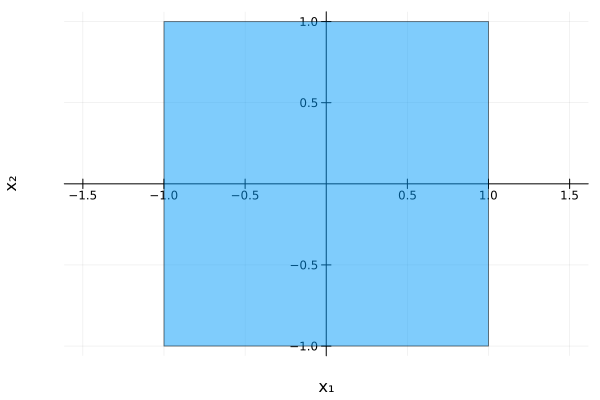

In [16]:
plot(z, alpha=0.5, framestyle=:origin, xlabel="x₁", ylabel="x₂", aspect_ratio=:equal)

ẑ₁ = Zonotope([1.0 1.0; 1.0 -1.0], [0.0, 0.0], [0.0 0.0])


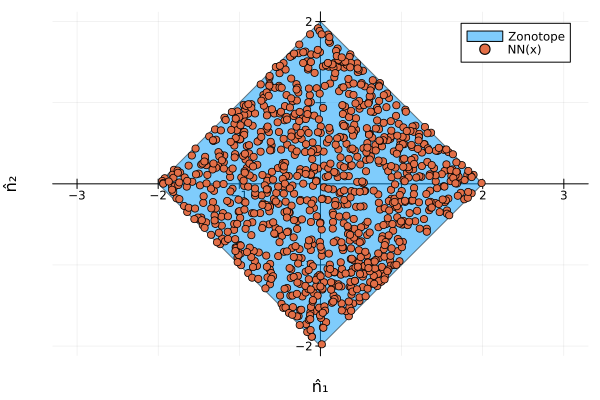

In [17]:
ẑ₁ = layers[1](z, prop_state)

@show ẑ₁

ys = sample_nn(nn, z, max_layer=1, n_samples=1000)

plot(ẑ₁, alpha=0.5, framestyle=:origin, xlabel="n̂₁", ylabel="n̂₂", aspect_ratio=:equal, label="Zonotope")
scatter!(ys[1,:], ys[2,:], label="NN(x)")

z₁ = Zonotope([0.5 0.5 0.5 0.0; 0.5 -0.5 0.0 0.5], [0.5, 0.5], [0.0 0.0 0.0 0.0])


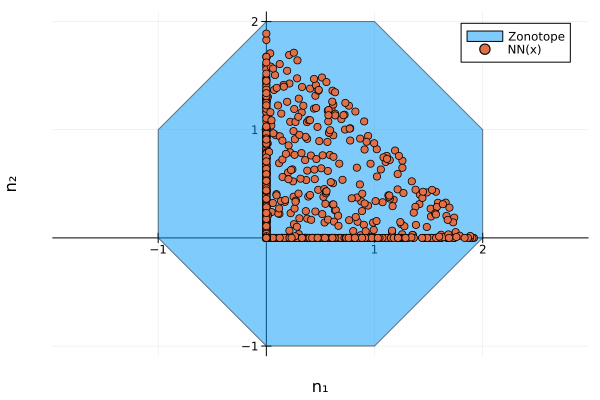

In [18]:
z₁ = layers[2](ẑ₁, prop_state)

@show z₁

ys = sample_nn(nn, z, max_layer=2, n_samples=1000)

plot(z₁, alpha=0.5, framestyle=:origin, xlabel="n₁", ylabel="n₂", aspect_ratio=:equal, label="Zonotope")
scatter!(ys[1,:], ys[2,:], label="NN(x)")

In [19]:
@show layers[3]

layers[3] = Dense([1.0 1.0; 1.0 -1.0], [-0.5, 0.0])


Dense([1.0 1.0; 1.0 -1.0], [-0.5, 0.0])

ẑ₂ = Zonotope([1.0 0.0 0.5 0.5; 0.0 1.0 0.5 -0.5], [0.5, 0.0], [0.0 0.0 0.0 0.0])


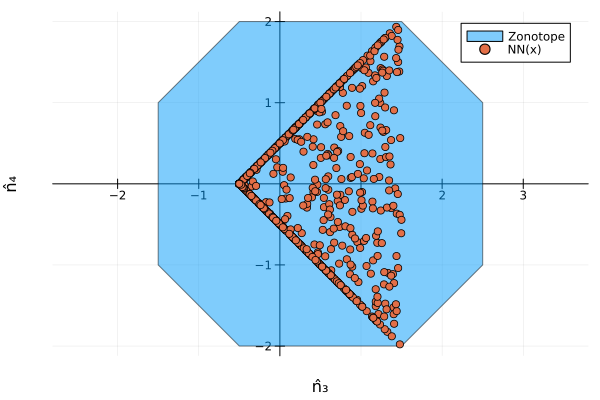

In [20]:
ẑ₂ = layers[3](z₁, prop_state)

@show ẑ₂

ys = sample_nn(nn, z, max_layer=3, n_samples=1000)

plot(ẑ₂, alpha=0.5, framestyle=:origin, xlabel="n̂₃", ylabel="n̂₄", aspect_ratio=:equal, label="Zonotope")
scatter!(ys[1,:], ys[2,:], label="NN(x)")

In [21]:
@show layers[4]

layers[4] = ReLU()


ReLU()

z₂ = Zonotope([0.625 0.0 0.3125 0.3125 0.46875 0.0; 0.0 0.5 0.25 -0.25 0.0 0.5], [0.78125, 0.5], [0.0 0.0 0.0 0.0 0.0 0.0])


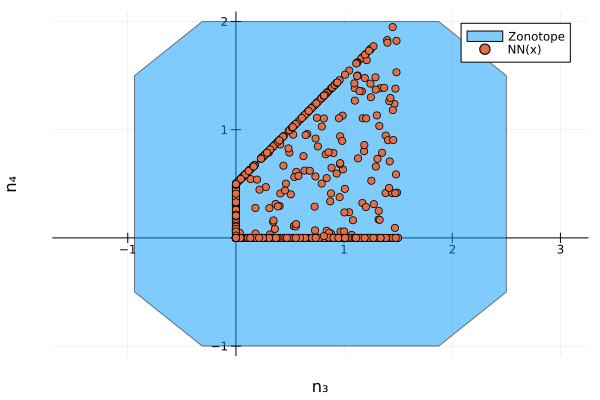

In [22]:
z₂ = layers[4](ẑ₂, prop_state)

@show z₂

ys = sample_nn(nn, z, max_layer=4, n_samples=1000)

plot(z₂, alpha=0.5, framestyle=:origin, xlabel="n₃", ylabel="n₄", aspect_ratio=:equal, label="Zonotope")
scatter!(ys[1,:], ys[2,:], label="NN(x)")

In [23]:
@show layers[5]

layers[5] = Dense([-1.0 0.0; 1.0 1.0], [0.0, 0.0])


Dense([-1.0 0.0; 1.0 1.0], [0.0, 0.0])

ẑ₃ = Zonotope([-0.625 0.0 -0.3125 -0.3125 -0.46875 0.0; 0.625 0.5 0.5625 0.0625 0.46875 0.5], [-0.78125, 1.28125], [0.0 0.0 0.0 0.0 0.0 0.0])


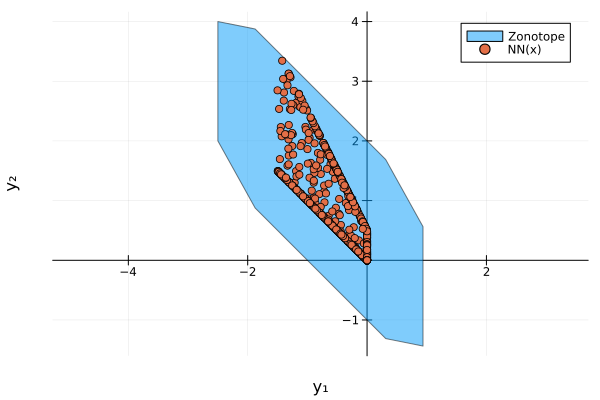

In [24]:
ẑ₃ = layers[5](z₂, prop_state)

@show ẑ₃

ys = sample_nn(nn, z, max_layer=5, n_samples=1000)

plot(ẑ₃, alpha=0.5, framestyle=:origin, xlabel="y₁", ylabel="y₂", aspect_ratio=:equal, label="Zonotope")
scatter!(ys[1,:], ys[2,:], label="NN(x)")

# Refinement via Input Splitting

Can you find a partition of the input s.t. you can prove that $y_2 > -2$?

In [25]:
# we can also define Zonotopes directly by the lower and upper bounds of the variables
z = Zonotope([-1., -1.], [1., 1.])  # original input set

# splits
zs = [
    Zonotope([-1., -1.], [0., 1])
    Zonotope([ 0., -1.], [1., 1])
]

2-element Vector{Zonotope}:
 Zonotope([0.5 0.0; 0.0 1.0], [-0.5, 0.0], [1.0 0.0; 0.0 1.0])
 Zonotope([0.5 0.0; 0.0 1.0], [0.5, 0.0], [1.0 0.0; 0.0 1.0])

You can visually check, if your splits are a partition of the initial input set.

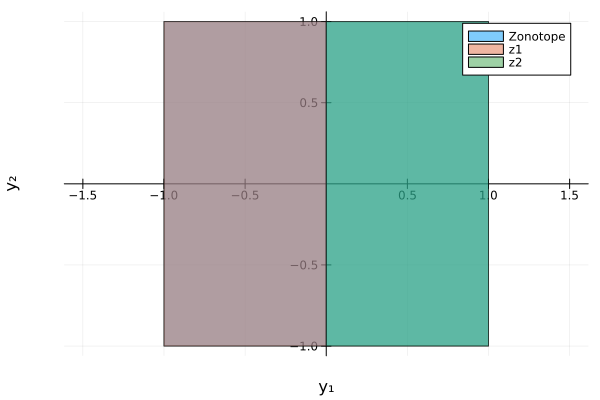

In [26]:
p = plot(z, alpha=0.5, framestyle=:origin, xlabel="y₁", ylabel="y₂", aspect_ratio=:equal, label="Zonotope")

for (i, zi) in enumerate(zs)
    plot!(zi, alpha=0.5, label="z$i")
end

p

In [27]:
zs_out = [nn(zi, prop_state) for zi in zs]

2-element Vector{Zonotope}:
 Zonotope([-0.1388888888888889 0.0 … -0.24305555555555558 0.0; 0.1388888888888889 0.3333333333333333 … 0.24305555555555558 0.33333333333333337], [-0.17361111111111116, 0.5069444444444445], [1.0 0.0 … 0.6666666666666667 0.33333333333333337; 0.0 1.0 … 0.6666666666666667 1.3333333333333335])
 Zonotope([-0.5416666666666666 0.0 … -0.20312500000000003 0.0; 0.5416666666666666 0.6666666666666666 … 0.20312500000000003 0.5], [-0.8802083333333335, 1.3802083333333335], [1.0 0.0 … 1.0 0.33333333333333337; 0.0 1.0 … 0.6666666666666667 2.0])

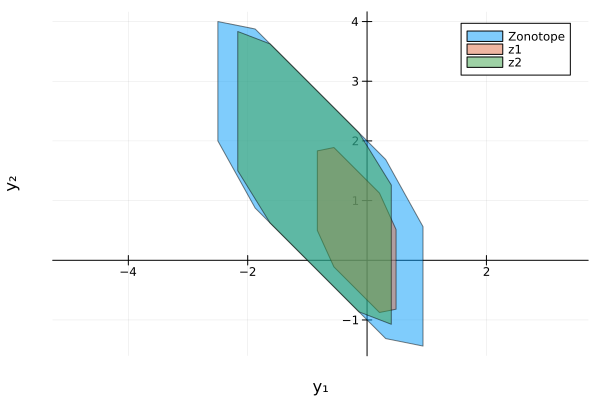

In [28]:
ẑ₃ = nn(z, prop_state)
p = plot(ẑ₃, alpha=0.5, framestyle=:origin, xlabel="y₁", ylabel="y₂", aspect_ratio=:equal, label="Zonotope")

for (i, zi) in enumerate(zs_out)
    plot!(zi, alpha=0.5, label="z$i")
end

p

# Equivalence Verification

Now we define another network with very similar weight matrices to our original network.

We want to prove that their absolute output difference is $\leq 1$ for our input set.

In [29]:
W1a = [1 1.1; 1 -0.9]
b1a = zeros(2)
W2a = [1.1 1; 0.9 -1]
b2a = [-0.4, 0]
W3a = [-1 0; 1 1.1]
b3a = zeros(2)

layersa = [Dense(W1a, b1a), ReLU(), Dense(W2a, b2a), ReLU(), Dense(W3a, b3a)]

nn1 = nn;
nn2 = Network(layersa);

If we just propagate our input zonotope individually through each network, this is what we get:

In [30]:
z = Zonotope(-ones(2), ones(2))
prop_state = PropState(true)

z1 = nn1(z, prop_state)
z2 = nn2(z, prop_state);

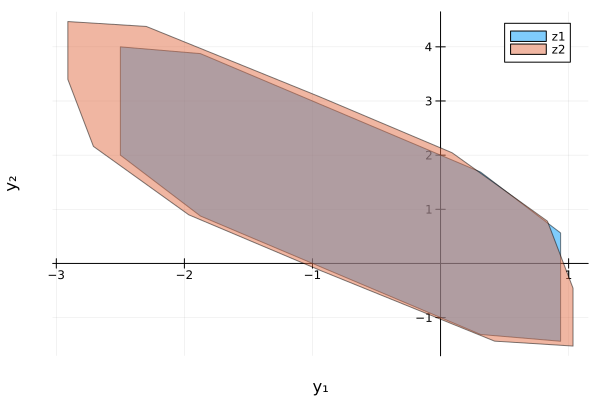

In [31]:
plot(z1, label="z1", alpha=0.5, framestyle=:origin, xlabel="y₁", ylabel="y₂")
plot!(z2, label="z2", alpha=0.5)

Can you write a function that computes a zonotope overapproximating the possible values of $NN_1(z) - NN_2(z)$?

In [32]:
function difference_bounds(net1, net2, z)
    # TODO: complete this method
end

difference_bounds (generic function with 1 method)

You can test the correctness of your function using sampled points.

In [33]:
zΔ = difference_bounds(nn1, nn2, z)

In [34]:
xs = sample_zono(z, n_samples=1000)

ys1 = hcat([nn1(Vector(xi)) for xi in eachcol(xs)]...)
ys2 = hcat([nn2(Vector(xi)) for xi in eachcol(xs)]...)

plot(zΔ, alpha=0.5, framestyle=:origin, label="zΔ")
plot!(zΔ2, alpha=0.5, label="zΔ2")
scatter!(ys1[1,:] .- ys2[1,:], ys1[2,:] .- ys2[2,:], label="sampled")

MethodError: MethodError: no method matching axes(::Nothing, ::Int64)
The function `axes` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  axes(!Matched::Core.SimpleVector, ::Integer)
   @ Base essentials.jl:947
  axes(!Matched::Base.Broadcast.Broadcasted{<:Any, <:NTuple{N, T} where T}, ::Integer) where N
   @ Base broadcast.jl:239
  axes(!Matched::Number, ::Integer)
   @ Base number.jl:83
  ...


## Functions for just the Zonotope Difference

In [35]:
function difference_zonotope(z1, z2, n_in)
    # TODO: complete this function

    # This would be an error, because they don't care about separate generators
    G = z1.G .- z2.G
    c = z1.c .- z2.c

    return Zonotope(G, c)
end

difference_zonotope (generic function with 1 method)

In [36]:
function difference_zonotope2(z1, z2, n_in)
    # this would work in this instance (when we always have more than n_in generators
    G_shared = z1.G[:,1:n_in] .- z2.G[:,1:n_in]
    G = [G_shared z1.G[:,n_in+1:end] .-z2.G[:,n_in+1:end]]

    c = z1.c .- z2.c

    return Zonotope(G, c)
end

difference_zonotope2 (generic function with 1 method)

# Differential Verification Layer by Layer

We define a structure that captures all three networks that are involved:
- $NN_1$
- $NN_2$
- and the difference network

In [37]:
nn_diff = GeminiNetwork(nn1, nn2);

Distance: 0.20000000000000007
Distance: 0.20000000000000007
Distance: 0.10000000000000009


We also have an input zonotope and set the initial difference zonotope to $0$ (as both networks are evaluated on the same inputs).

In [38]:
∂z = Zonotope(zero(z.G), zero(z.c), nothing)
zΔ = DiffZonotope(z, deepcopy(z), ∂z, 0, 0, 0)

prop_state = PropState(true);

We can now watch how the difference zonotope for the naive approach grows vs the zonotope for the differential verification.

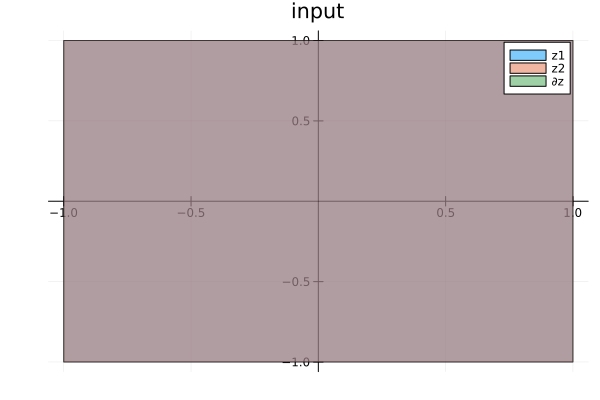

In [39]:
plot(zΔ.Z₁, label="z1", framestyle=:origin, alpha=0.5, title="input")
plot!(zΔ.Z₂, label="z2", alpha=0.5)
plot!(zΔ.∂Z, label="∂z", alpha=0.5)

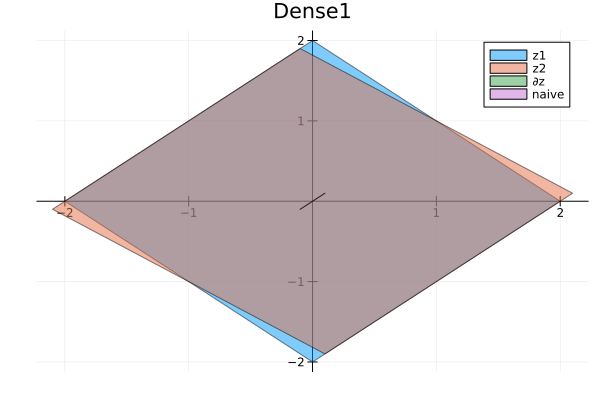

In [40]:
zΔ1 = VeryDiff.propagate_diff_layer((nn_diff.network1.layers[1], nn_diff.diff_network.layers[1], nn_diff.network2.layers[1]), zΔ, prop_state)

plot(zΔ1.Z₁, label="z1", framestyle=:origin, alpha=0.5, title="Dense1")
plot!(zΔ1.Z₂, label="z2", alpha=0.5)
plot!(zΔ1.∂Z, label="∂z", alpha=0.5)
# naive difference
z_diff = difference_zonotope2(zΔ1.Z₁, zΔ1.Z₂, 2)
plot!(z_diff, label="naive", alpha=0.5)

Instable Generators: 2


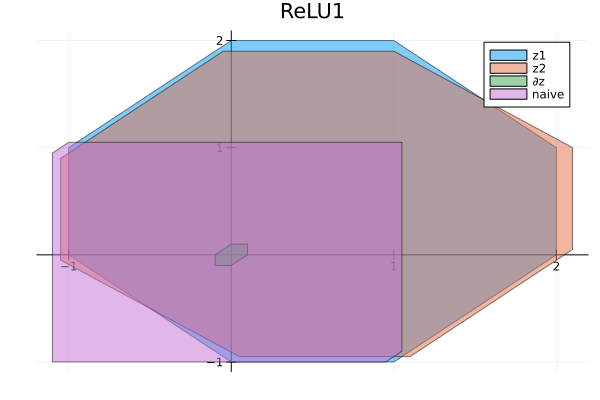

In [41]:
i = 2
zΔ2 = VeryDiff.propagate_diff_layer((nn_diff.network1.layers[i], nn_diff.diff_network.layers[i], nn_diff.network2.layers[i]), zΔ1, prop_state)

plot(zΔ2.Z₁, label="z1", framestyle=:origin, alpha=0.5, title="ReLU1")
plot!(zΔ2.Z₂, label="z2", alpha=0.5)
plot!(zΔ2.∂Z, label="∂z", alpha=0.5)

z_diff = difference_zonotope2(zΔ2.Z₁, zΔ2.Z₂, 2)
plot!(z_diff, label="naive", alpha=0.5)

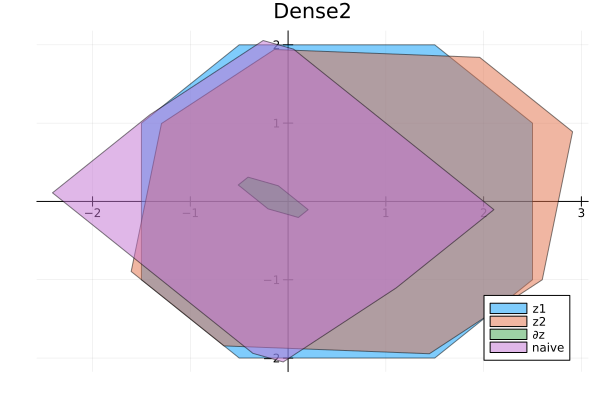

In [42]:
i = 3
zΔ3 = VeryDiff.propagate_diff_layer((nn_diff.network1.layers[i], nn_diff.diff_network.layers[i], nn_diff.network2.layers[i]), zΔ2, prop_state)

plot(zΔ3.Z₁, label="z1", framestyle=:origin, alpha=0.5, title="Dense2")
plot!(zΔ3.Z₂, label="z2", alpha=0.5)
plot!(zΔ3.∂Z, label="∂z", alpha=0.5)

z_diff = difference_zonotope2(zΔ3.Z₁, zΔ3.Z₂, 2)
plot!(z_diff, label="naive", alpha=0.5)

Instable Generators: 2


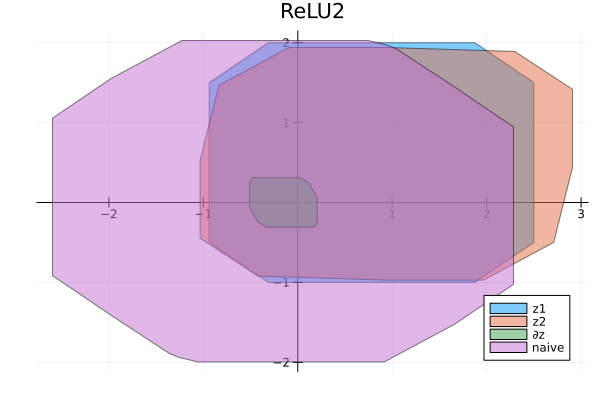

In [43]:
i = 4
zΔ4 = VeryDiff.propagate_diff_layer((nn_diff.network1.layers[i], nn_diff.diff_network.layers[i], nn_diff.network2.layers[i]), zΔ3, prop_state)

plot(zΔ4.Z₁, label="z1", framestyle=:origin, alpha=0.5, title="ReLU2")
plot!(zΔ4.Z₂, label="z2", alpha=0.5)
plot!(zΔ4.∂Z, label="∂z", alpha=0.5)

z_diff = difference_zonotope2(zΔ4.Z₁, zΔ4.Z₂, 2)
plot!(z_diff, label="naive", alpha=0.5)

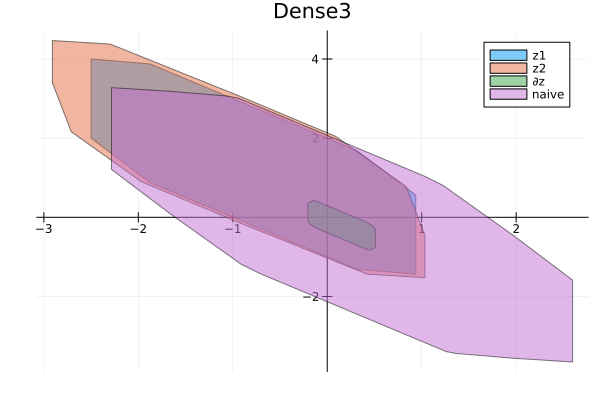

In [44]:
i = 5
zΔ5 = VeryDiff.propagate_diff_layer((nn_diff.network1.layers[i], nn_diff.diff_network.layers[i], nn_diff.network2.layers[i]), zΔ4, prop_state)

plot(zΔ5.Z₁, label="z1", framestyle=:origin, alpha=0.5, title="Dense3")
plot!(zΔ5.Z₂, label="z2", alpha=0.5)
plot!(zΔ5.∂Z, label="∂z", alpha=0.5)

z_diff = difference_zonotope2(zΔ5.Z₁, zΔ5.Z₂, 2)
plot!(z_diff, label="naive", alpha=0.5)

# Larger Examples

We can now try `VeryDiff` (and the state-of-the-art non-differential verifier $\alpha$-$\beta$-CROWN) on larger MNIST networks.

In [45]:
net1 = load_network("/data/mnist_relu_3_100.onnx");
net2 = load_network("/data/mnist_relu_3_100_pruned5.onnx");

SystemError: SystemError: opening file "/data/mnist_relu_3_100.onnx": No such file or directory

Choose a property to verify

In [46]:
f, n_in, n_out = get_ast("/data/mnist_9_global_3.vnnlib");
#f, n_in, n_out = get_ast("/software/networks/mnist_67_global_6.vnnlib");
#f, n_in, n_out = get_ast("/data/mnist_90_global_4.vnnlib");
#f, n_in, n_out = get_ast("/data/mnist_55_local_24.vnnlib");
#f, n_in, n_out = get_ast("/data/mnist_64_local_15.vnnlib");

SystemError: SystemError: opening file "/data/mnist_9_global_3.vnnlib": No such file or directory

And see how `VeryDiff` performs.

You can also go back to the section about adversarial attacks: Are there any contradictions? Are there cases, where `VeryDiff` can find counterexamples that PGD could not find?

In [47]:
for (bounds, matrix, bias, num) in f
   prop = get_epsilon_property(1.)
   verify_network(net1, net2, bounds[1:n_in,:], prop, epsilon_split_heuristic, timeout=120.)
end

Distance: 296.6600370998244
Distance: 77.24290861755458
Distance: 5.7170369567975285
Distance: 0.0
Running with 1 threads
[Thread 1] Time to first task: 0.0s
Instable Generators: 37
Instable Generators: 68
Instable Generators: 7
Zono Bounds:
[0.0, -0.7904220713115353, -0.7422137705342859, -0.753824280882265, -0.8743431017859247, -1.4009581711988253, 0.0, -0.9989215151861448, -0.7519684474847415, -0.5925230997742432]
[0.0, 0.7904220713115353, 0.6388932686890085, 0.753824280882265, 0.8743431017859249, 0.9791363845182015, 0.0, 0.9989215151861448, 0.7519684474847415, 0.6988760351054084]
[Thread 1] Processed 100 zonotopes (Work Done: 0.0%; Expected Zonos: Inf)
[Thread 1] Processed 200 zonotopes (Work Done: 2.34375%; Expected Zonos: 8533.333333333334)
[Thread 1] Processed 300 zonotopes (Work Done: 12.5%; Expected Zonos: 2400.0)
[Thread 1] Processed 400 zonotopes (Work Done: 24.02344%; Expected Zonos: 1665.040650406504)
[Thread 1] Processed 500 zonotopes (Work Done: 32.91016%; Expected Zonos:

To run $\alpha$-$\beta$-CROWN, you need to start a terminal and enter
```bash
$ cd /software/abCROWN
$ conda activate alpha-beta-crown
$ python complete_verifier/abcrown.py --onnx_path /data/product_mnist_relu_3_100_mnist_relu_3_100_pruned5_eps.onnx --vnnlib_path /data/product_mnist_67_global_6_eps_1.0.vnnlib --device cpu --config /data/mnistfc_modifed.yaml 
```
you can adjust `--vnnlib_path` as you wish. 

Just make sure to always choose the `product_mnist...` property (which encodes the naive difference).

How does it compare to `VeryDiff` (on UNSAT/SAT instances)?